# Calculating Barriers in Metal - Semiconductor junctions 
- all calculations indepandant of the material
- for both p and n-type


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import pandas as pd

### Physical Constants

In [ ]:
Q = 1.602e-19  # Elementary charge (C)
EPSILON_0 = 8.854e-14  # Permittivity of free space (As/Vcm) -> in cm here to math the doping concentration units
K_B_eV = 8.617e-5  # Boltzmann constant (eV/K)
K_B_J = 1.380649e-23  # Boltzmann constant (J/K)
T = 300  # Temperature (K)
H = 6.626e-34# planck constant (Js)

### Material Parameters Class
allows for easier swaps of materials

In [29]:
class MaterialParameters:
    """Stores and manages the material parameters for the semiconductor and metal."""
    def __init__(self, name, type, phi_s, chi, Nd_or_Na, epsilon_r, Nc=None, Nv=None, phi_0_CNL=None):
        """
        :param name: Material name (e.g., 'Silicon', 'Aluminium').
        :param type: 'n' or 'p' for semiconductor, 'metal' for metal.
        :param phi_s: Work function (eV) for metal OR band gap (Eg) for semiconductor.
        :param chi: Electron Affinity (eV) for semiconductor.
        :param Nd_or_Na: Donor (Nd) or Acceptor (Na) concentration (atoms/cm^3) for semiconductor.
        :param epsilon_r: Relative permittivity (dielectric constant).
        :param Nc: Effective Density of States in Conduction Band (cm^-3).
        :param Nv: Effective Density of States in Valence Band (cm^-3).
        :param phi_0_CNL: charge neutrality level (eV).
        """
        self.name = name
        self.type = type
        self.phi_s = phi_s # Work function or Eg
        self.chi = chi
        self.Nd_or_Na = Nd_or_Na
        self.epsilon_r = epsilon_r
        # Calculate absolute permittivity (F/cm)
        if self.epsilon_r is not None: self.epsilon = self.epsilon_r * EPSILON_0
        
        self.Nc = Nc
        self.Nv = Nv
        self.phi_0_CNL = phi_0_CNL

### Junction Calculation Class
- ideal barrier
- fermi level pinning
- depletion width

In [32]:
class JunctionCalculator:
    """Performs calculations for the metal-semiconductor junction."""

    def __init__(self, metal, semiconductor):
        self.metal = metal
        self.semiconductor = semiconductor
        self.type = semiconductor.type.lower() # 'n' or 'p'


    def _calculate_fermi_level_position(self):
        """
        Calculates the Fermi level position relative to the band edge (in eV).
        This result is E_c - E_F for n-type or E_F - E_v for p-type.
        """
        kBT_over_q = K_B_eV * T # k_B T/q (in Volts)

        if self.type == 'n':
            # E_C-E_F = k_B T/q * ln (N_D/N_C) (in V)
                        
            # NOTE: We must ensure N_D < N_C for the Boltzmann approximation to be valid
            N_D = self.semiconductor.Nd_or_Na
            N_C = self.semiconductor.Nc
            
            if N_D > N_C:
                # Fermi level is in the conduction band (degenerate case)
                print("n--- WARNING: Degenerate doping (ND > NC). Result may be inaccurate. ---")
            
            V_n = kBT_over_q * np.log(self.semiconductor.Nc / N_D)
            return V_n
            
        elif self.type == 'p':
            # E_F - E_V = k_B T/q * ln(N_A/N_V) (in V)
            N_A = self.semiconductor.Nd_or_Na
            N_V = self.semiconductor.Nv

            if N_A > N_V:
                print("n--- WARNING: Degenerate doping (NA > NV). Result may be inaccurate. ---")
                
            V_p = kBT_over_q * np.log(self.semiconductor.Nv / N_A)
            return V_p
        
        else:
            raise ValueError("Semiconductor type must be 'n' or 'p'.")


    def _calculate_v_bi(self):
            """
            Calculates the built-in potential (V_bi) based on the Schottky-Mott model:
            V_bi = 1/q * (Phi_m - Phi_s), where Phi_s is the semiconductor work function.
            
            V_bi (n-type) = Phi_m - chi - V_n       (in Volts)
            V_bi (p-type) = Phi_m - chi - E_g + V_p (in Volts)
            
            Where Phi_m, chi, E_g are in eV and V_n, V_p are in Volts.
            Since V_n and V_p are already calculated in Volts, the formula simplifies.
            """
            phi_m = self.metal.phi_s        # Phi_m (eV)
            chi = self.semiconductor.chi    # chi (eV)
            Eg = self.semiconductor.phi_s   # E_g (eV)

            # Fermi level position relative to band edge, V_n or V_p (in Volts)
            V_fermi_band_edge = self._calculate_fermi_level_position() 

            if self.type == 'n':
                # The semiconductor work function is Phi_s = chi + (E_c - E_F)/q = chi + V_n
                # V_bi = (Phi_m - Phi_s)/q
                # V_bi = Phi_m - chi - V_fermi_band_edge
                V_bi = phi_m - chi - V_fermi_band_edge
                
            elif self.type == 'p':
                # The semiconductor work function is Phi_s = chi + E_g - (E_F - E_v)/q = chi + E_g - V_p
                # V_bi = Phi_m - (chi + E_g - V_fermi_band_edge)
                V_bi = phi_m - (chi + Eg - V_fermi_band_edge)
            
            else:
                raise ValueError("Semiconductor type must be 'n' or 'p'.")
                
            return V_bi



    def ideal_barrier_height(self):
            """
            Calculates the ideal Schottky Barrier Height Phi_B,ideal
            """
            phi_m = self.metal.phi_s # Metal work function (eV)
            chi = self.semiconductor.chi # Electron Affinity (eV)
            
            if self.type == 'n':
                # Phi_{Bn, ideal} = Phi_m - chi
                phi_b_ideal = phi_m - chi
            elif self.type == 'p':
                Eg = self.semiconductor.phi_s # Band gap (eV)
                # Phi_{Bp, ideal} = E_g - (Phi_m - chi)
                phi_b_ideal = Eg - (phi_m - chi)
            else:
                raise ValueError("Semiconductor type must be 'n' or 'p'")

            return phi_b_ideal
        
        
    def barrier_height_pinning(self, S):
        """
        Calculates the barrier height with Fermi Level Pinning
        :param S: Pinning factor (0 < S < 1). S=1 is ideal, S=0 is full pinning.
        """
        phi_m = self.metal.phi_s # Metal work function (eV)
        chi = self.semiconductor.chi # Electron Affinity (eV)
        phi_0_CNL = self.semiconductor.phi_0_CNL # charge neutrality level (eV)
        E_g = self.semiconductor.phi_s # Band gap (eV)

        if self.type == 'n':
            Phi_B = S * (phi_m - chi) + (1 - S) * (E_g - phi_0_CNL)         # * phi_0_CNL or * *(E_g - phi_0_CNL)?
        elif self.type == 'p':
            Phi_B = S * (E_g + chi - phi_m) + (1 - S) * phi_0_CNL
        else:
            raise ValueError("Semiconductor type must be 'n' or 'p'")

        return Phi_B


    def depletion_width(self, V_ext=0):
            """
            Calculates the depletion width (W) at a given applied voltage (V_ext).
            Requires the built-in voltage (V_bi).
            """
            V_bi = self._calculate_v_bi()
            N = self.semiconductor.Nd_or_Na
            epsilon = self.semiconductor.epsilon

            # W = sqrt{2 epsilon (V_bi - V_a)/Q N}
            try:
                W = np.sqrt((2 * epsilon * (V_bi - V_ext)) / (Q * N))
            except ValueError:
                print("Error: (V_bi - V_ext) is negative. Check inputs or V_bi calculation.")
                W = 0
                
            return W * 1e7 # Convert cm to nm

# Testing

## Material definitions

In [30]:
# def SiC parameters
n_SiC = MaterialParameters(
    name='n_SiC',
    type='n',
    phi_s=3.26,
    chi=3.2,
    Nd_or_Na=4.33e17,
    epsilon_r=9.7,
    Nc=1.7e19,
    Nv=2.5e19,
    phi_0_CNL=1.51)

Ni2Si = MaterialParameters(
    name='Ni2Si',
    type='metal',
    phi_s=4.8,
    chi=None,
    Nd_or_Na=None,
    epsilon_r=None)

print(n_SiC.__dict__)
print(Ni2Si.__dict__)

{'name': 'n_SiC', 'type': 'n', 'phi_s': 3.26, 'chi': 3.2, 'Nd_or_Na': 4.33e+17, 'epsilon_r': 9.7, 'epsilon': 8.588379999999999e-13, 'Nc': 1.7e+19, 'Nv': 2.5e+19, 'phi_0_CNL': 1.51}
{'name': 'Ni2Si', 'type': 'metal', 'phi_s': 4.8, 'chi': None, 'Nd_or_Na': None, 'epsilon_r': None, 'Nc': None, 'Nv': None, 'phi_0_CNL': None}


In [31]:
phi_m = JunctionCalculator(Ni2Si, n_SiC).ideal_barrier_height()
print(phi_m, ' eV')

w_scr = JunctionCalculator(Ni2Si, n_SiC).depletion_width()
print(w_scr, ' nm')

1.5999999999999996  eV
61.04935885535295  nm


[np.float64(1.7499999999999998), np.float64(1.7484848484848485), np.float64(1.7469696969696966), np.float64(1.7454545454545454), np.float64(1.7439393939393937), np.float64(1.7424242424242422), np.float64(1.7409090909090907), np.float64(1.7393939393939393), np.float64(1.7378787878787876), np.float64(1.736363636363636), np.float64(1.7348484848484846), np.float64(1.7333333333333332), np.float64(1.7318181818181815), np.float64(1.7303030303030302), np.float64(1.7287878787878785), np.float64(1.727272727272727), np.float64(1.7257575757575754), np.float64(1.7242424242424241), np.float64(1.7227272727272722), np.float64(1.721212121212121), np.float64(1.7196969696969697), np.float64(1.7181818181818178), np.float64(1.7166666666666663), np.float64(1.7151515151515149), np.float64(1.7136363636363634), np.float64(1.7121212121212117), np.float64(1.7106060606060605), np.float64(1.709090909090909), np.float64(1.7075757575757573), np.float64(1.7060606060606058), np.float64(1.7045454545454546), np.float64(

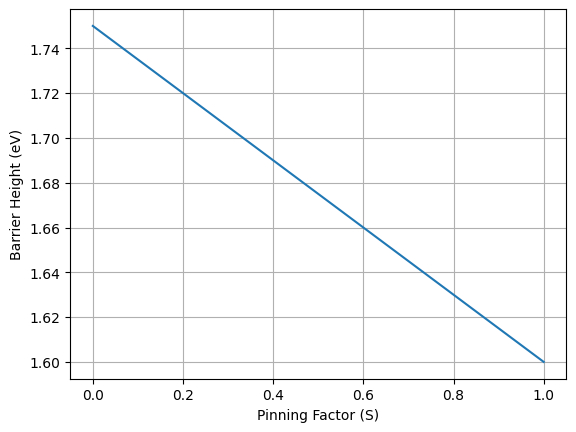

In [ ]:
# make a sweep of the pinning factor S from 0 to 1
S_values = np.linspace(0, 1, 100)
phi_b_pinning = [JunctionCalculator(Ni2Si, n_SiC).barrier_height_pinning(s) for s in S_values]
print(phi_b_pinning)

plt.plot(S_values, phi_b_pinning)
plt.xlabel('Pinning Factor (S)')
plt.ylabel('Barrier Height (eV)')
plt.grid()
plt.show()

maybe try making plots with a voltage sweep and the depletion width


In [ ]:
JunctionCalculator(Ni2Si, n_SiC)._calculate_v_bi()

np.float64(150.51208611324276)

[np.float64(61.04935885535295), np.float64(60.74024619138922), np.float64(60.42955235753021), np.float64(60.11725283870179), np.float64(59.80332247971939), np.float64(59.48773546164136), np.float64(59.170465276987095), np.float64(58.85148470375278), np.float64(58.530765778152606), np.float64(58.20827976600814), np.float64(57.88399713270314), np.float64(57.55788751161475), np.float64(57.229919670925725), np.float64(56.90006147871479), np.float64(56.56827986621509), np.float64(56.23454078912131), np.float64(55.89880918681775), np.float64(55.56104893938895), np.float64(55.2212228222636), np.float64(54.87929245833075), np.float64(54.53521826735372), np.float64(54.188959412493084), np.float64(53.840473743734236), np.float64(53.48971773799754), np.float64(53.13664643569032), np.float64(52.78121337343879), np.float64(52.4233705127149), np.float64(52.063068164047905), np.float64(51.70025490648195), np.float64(51.33487750191018), np.float64(50.966880803881224), np.float64(50.59620766043586), np

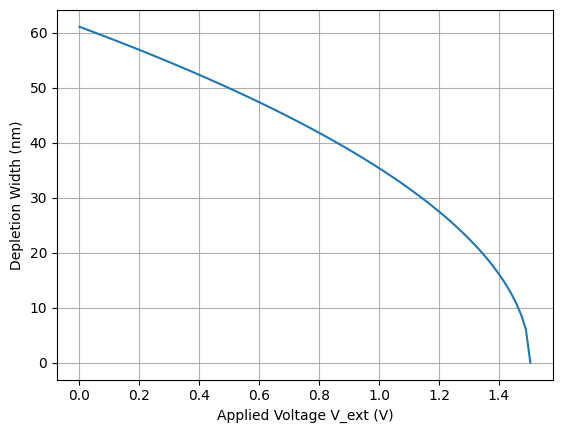

In [50]:
# make a sweep of the applyed voltage V_ext vs. the depletion width
V_ext_values = np.linspace(0, JunctionCalculator(Ni2Si, n_SiC)._calculate_v_bi(), 100)
w_scr_values = [JunctionCalculator(Ni2Si, n_SiC).depletion_width(V_ext) for V_ext in V_ext_values]
print(w_scr_values)

plt.plot(V_ext_values, w_scr_values)
plt.xlabel('Applied Voltage V_ext (V)')
plt.ylabel('Depletion Width (nm)')
plt.grid()  
plt.show()

In [ ]:
# def main():
#     print("--- Metal-Semiconductor Junction Calculator ---")
#     # Metal (Aluminium): Work function $\Phi_m$
#     Al = MaterialParameters(
#         name='Aluminium',
#         type='metal',
#         phi_s=4.28, # Work function (eV)
#         chi=None,
#         Nd_or_Na=None,
#         epsilon_r=None
#     )

#     # Semiconductor Substrate (n-type Silicon):
#     # $\Phi_s$ = Band gap $E_g$
#     # $\chi$ = Electron Affinity
#     # $\epsilon_r$ = Relative Permittivity
#     n_Si = MaterialParameters(
#         name='n-Silicon',
#         type='n',
#         phi_s=1.12, # $E_g$ (eV)
#         chi=4.05, # $\chi$ (eV)
#         Nd_or_Na=1e16, # $N_d$ (atoms/cm^3)
#         epsilon_r=11.7
#     )

#     # Semiconductor Substrate (p-type Silicon):
#     p_Si = MaterialParameters(
#         name='p-Silicon',
#         type='p',
#         phi_s=1.12, # $E_g$ (eV)
#         chi=4.05, # $\chi$ (eV)
#         Nd_or_Na=5e15, # $N_a$ (atoms/cm^3)
#         epsilon_r=11.7
#     )
    
#     # --- Select Junction Type ---
#     # Change this to switch between n-type and p-type calculations
#     # substrate = n_Si
#     substrate = p_Si

#     print(f"\nJunction: {Al.name} on {substrate.name}")
#     junction = JunctionCalculator(Al, substrate)

#     # --- Perform Calculations ---

#     ## Ideal Barrier Height
#     phi_b_ideal = junction.ideal_barrier_height()
#     print(f"\n1. Ideal Barrier Height ($\Phi_{{B, ideal}}$): {phi_b_ideal:.3f} eV")

#     ## Barrier Height with Fermi Level Pinning (Single S value)
#     pinning_factor_S = 0.3
#     phi_b_pinning = junction.barrier_height_pinning(pinning_factor_S)
#     print(f"2. Barrier Height (S={pinning_factor_S}): {phi_b_pinning:.3f} eV")

#     # Optional: Plot Barrier Height vs. Pinning Factor (0 < S < 1)
#     print("\n2b. Barrier Height vs. Pinning Factor (S)")
#     S_values = np.linspace(0.0, 1.0, 11)
#     for S in S_values:
#         phi_b_S = junction.barrier_height_pinning(S)
#         print(f"   S={S:.1f}: $\Phi_B$ = {phi_b_S:.3f} eV")
    
#     ## Depletion Width (W)
#     # NOTE: This depends on the $V_{bi}$ calculation which needs to be correctly implemented!
#     W_at_zero_bias = junction.depletion_width(V_a=0)
#     print(f"\n3. Depletion Width at Zero Bias ($W_0$): {W_at_zero_bias:.3e} $\mu$m")

#     # --- Call to action for user ---
#     print("\n--- NEXT STEPS ---")
#     print("1. Implement the correct equation for $\mathbf{V_{bi}}$ calculation (built-in potential), which depends on the Fermi Level position ($E_F$).")
#     print("2. Implement the correct equation for $\mathbf{\Phi_B}$ with pinning (if different from the simplified linear interpolation).")

# if __name__ == "__main__":
#     main()